In [1]:
#!pip install torch

In [3]:
path =r'https://raw.githubusercontent.com/ayushj654/Hangman_RL_cuda/main/words_250000_train.txt'


'grep' is not recognized as an internal or external command,
operable program or batch file.


In [1]:

import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import string
import numpy as np

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
device

device(type='cuda')

In [4]:
#!pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/cu12.2/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu12.2/torch_stable.html
     ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
     ------ --------------------------------- 0.2/1.2 MB 5.9 MB/s eta 0:00:01
     --------------------- ------------------ 0.7/1.2 MB 8.3 MB/s eta 0:00:01
     ---------------------------------------  1.2/1.2 MB 9.4 MB/s eta 0:00:01
     ---------------------------------------- 1.2/1.2 MB 8.4 MB/s eta 0:00:00
     ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
     -------- ------------------------------- 0.5/2.1 MB 14.2 MB/s eta 0:00:01
     --------------- ------------------------ 0.8/2.1 MB 13.0 MB/s eta 0:00:01
     ---------------------- ----------------- 1.2/2.1 MB 10.6 MB/s eta 0:00:01
     --------------------------- ------------ 1.5/2.1 MB 10.4 MB/s eta 0:00:01
     -------------------------------- ------- 1.8/2.1 MB 8.6 MB/s eta 0:00:01
     ---------------------------------------  2.1/2.1 MB 7.9 MB/s eta 0:00:0

In [4]:
wordlist = pd.read_table(path,header=None)
word_list = wordlist[0].to_list()

In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [6]:
device

device(type='cuda')

In [15]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 26)
        self.layer2 = nn.Linear(26, 32)
        self.layer3 = nn.Linear(32, 32)
        self.layer4 = nn.Linear(32, 26)
        self.layer5 = nn.Linear(26, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x=F.softmax(self.layer5(x),dim=1)
        return x

In [16]:
def word_to_state(word):
  state = np.zeros(26)
  for i in range(len(word)):
      if word[i] in ('_'," "):
          continue
      state[ord(word[i])-97] += 1
  return state

In [17]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 0.99
EPS_END = 0.05
EPS_DECAY = 500
TAU = 0.01
LR = 0.01

# Get number of actions from gym action space
n_actions = 26
# Get the number of state observations
state=[0]*26
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
 #           x= policy_net(state).max(1)[1].view(1, 1)
            x= policy_net(state)
            #print("nn output action",policy_net(state))
            return x
    else:
       # print('random')
        x= torch.tensor(word_to_state(random.choice(list(string.ascii_lowercase))).reshape(1,-1), device=device, dtype=torch.long)
        #print('random =====>',x.size())
        return x


score = []


def plot_rewards(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(score, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('%words completed')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [18]:
word_to_state(random.choice(list(string.ascii_lowercase)))

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [19]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    #print("non final mask====>",non_final_mask)
    #print("non_final_next_states===>",non_final_next_states)

    #print("State batch before===>",batch.state)
    state_batch = torch.cat(batch.state)
    #print("State batch===>",state_batch)
   # print("Action batchj Max arg=====>",torch.argmax(batch.action))
    #print("Action batch before=====>",batch.action)
    #action_batch_tuple = tuple(tensor.view(1, -1) for tensor in batch.action)
    action_batch = torch.cat(batch.action)
    #print("Action batch =====>",action_batch)
    #print("Reward batch =====>",batch.reward)
    reward_batch = torch.cat(batch.reward)
    #print("Reward batch =====>",reward_batch)
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    #chk = policy_net(state_batch)
    #print("output tensor ====>",chk)
    #print("gathering ====>",chk.gather(1,torch.tensor([3]*chk.size()[1],device=device)))
    #state_action_values = chk.gather(1, action_batch)
    #print(action_batch.unsqueeze(1))

    #index_tensor = torch.tensor([tensor for tensor in action_batch],device=device)
    #print("getting index of max of each tensor",index_tensor)
    state_action_values=policy_net(state_batch).gather(1,torch.argmax(action_batch,dim=1).unsqueeze(1))
    #print("state_action_values=====>",state_action_values)
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    #print("target",target_net(non_final_next_states))
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    #print("next_state_values =====>",next_state_values)
    #print("target_net(non_final_next_states). ======>",target_net(non_final_next_states))
    #print("target_net(non_final_next_states).max(1) =======>",target_net(non_final_next_states).max(1))
    #print("target_net(non_final_next_states).max(1)[0] =======>",target_net(non_final_next_states).max(1)[0])
    #print("next_state_values[non_final_mask] ======>",next_state_values[non_final_mask])
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    #print("next_state_values=====>",next_state_values*GAMMA)
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    #print("expected_state_action_values====>",expected_state_action_values)
    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    #print("state_action_values ======>",state_action_values)
    #print("expected_state_action_values ======>",expected_state_action_values.unsqueeze(1))
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    #print(loss)
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [20]:
input = torch.tensor([[0., -1., 2., 8.],[16., -1., 2., 8.]],device=device)
torch.argmax(input)

tensor(4, device='cuda:0')

In [21]:
trials = -2
curr = 'ball'
tgt ='b_ll'
print((curr==tgt)*1 if trials>0 else -1)

-1


Complete


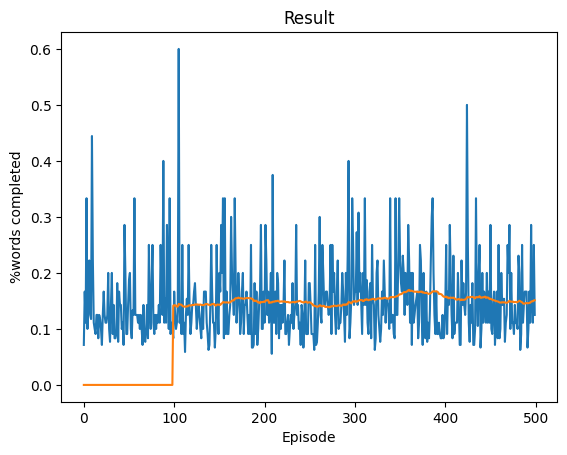

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [22]:
if torch.cuda.is_available():
    num_episodes = 500
else:
    num_episodes = 8

a=random.sample(range(0,len(word_list)),num_episodes)
wordlist1=[word_list[i] for i in a]

def reward_value(word):
    count = 0
    for w in word:
        if w.isalpha():
            count+=1
    return count/len(word)


def env(tgt,curr,action,trials):
  act_letter = chr(torch.argmax(action).item()+97)
  #print(torch.argmax(action),"====",torch.argmax(action).item(),"   ",act_letter)
  prev_rew=reward_value(curr)
  if act_letter in tgt:
    for i in range(len(tgt)):
      if tgt[i] == act_letter:
        curr= curr[:i]+act_letter+curr[i+1:]
    else:
      trials-=1
  return curr,(((reward_value(curr)>prev_rew)*reward_value(curr)*5)+((curr==tgt)*10))*(trials>0)+(trials<=0)*-1,curr==tgt,trials<=0,trials


for i_episode in range(num_episodes):
    trial_left = 6
    tgt_wrd = wordlist1[i_episode]
    # Initialize the environment and get it's state
    curr = '_'*len(tgt_wrd)
    state = torch.tensor([0]*26, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
  #      state = torch.tensor(word_to_state(curr), dtype=torch.float32, device=device).unsqueeze(0)
        action = select_action(state)
        #print("select action====>",action)

        observation, reward, terminated, truncated,trial_left = env(tgt_wrd,curr,action,trial_left)
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(word_to_state(observation), dtype=torch.float32, device=device).unsqueeze(0)
        #print("state=====>",state)
        #print("next state=====>",next_state)
        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            #print(observation)
            score.append(reward_value(observation))
            plot_rewards()
            break

print('Complete')
plot_rewards(show_result=True)
plt.ioff()
plt.show()

In [ ]:
np.mean(score)

0.1623802449184802

In [ ]:
memory.sample(1)

[Transition(state=tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.]], device='cuda:0'), action=tensor([[1.4197e-05, 2.2695e-05, 2.3632e-02, 6.8648e-04, 9.5331e-01, 7.6646e-06,
          8.4535e-06, 3.3272e-04, 2.4283e-04, 2.1577e-05, 9.2335e-05, 1.3108e-02,
          6.6969e-06, 9.4070e-05, 7.9961e-06, 5.3868e-05, 1.8746e-03, 3.7577e-05,
          5.4067e-03, 8.7436e-05, 9.9854e-05, 1.7533e-04, 5.8173e-04, 2.8410e-05,
          5.6171e-05, 1.0463e-05]], device='cuda:0'), next_state=tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.]], device='cuda:0'), reward=tensor([0.], device='cuda:0'))]